In [1]:
from huggingface_hub import notebook_login

notebook_login()
# !pip install -qq -U diffusers transformers

In [23]:
# DiT

from diffusers import DiTPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiTPipeline.from_pretrained(
    "facebook/DiT-XL-2-256", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# pick words from Imagenet class labels
pipe.labels  # to print all available words

# pick words that exist in ImageNet
words = ["white shark", "umbrella"]

class_ids = pipe.get_label_ids(words)

generator = torch.manual_seed(33)
output = pipe(class_labels=class_ids,
              num_inference_steps=50, generator=generator)

image = output.images[0]  # label 'white shark'

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

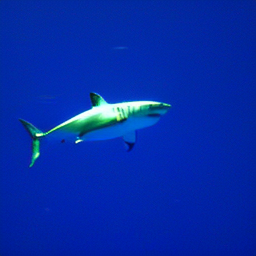

In [24]:
image

In [3]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import logging

# disable warnings
logging.disable(logging.WARNING)

# Import the CLIP artifacts

# Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float16
)
text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float16
).to("cuda")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [4]:
prompt = ["a dog wearing hat"]
tok = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
emb = text_encoder(tok.input_ids.to("cuda"))[0].half()
print(f"Shape of embedding : {emb.shape}")

Shape of embedding : torch.Size([1, 77, 768])


In [7]:
## To import an image from a URL
from fastdownload import FastDownload

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading a VAE model
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Dimension of this image: (512, 512, 3)


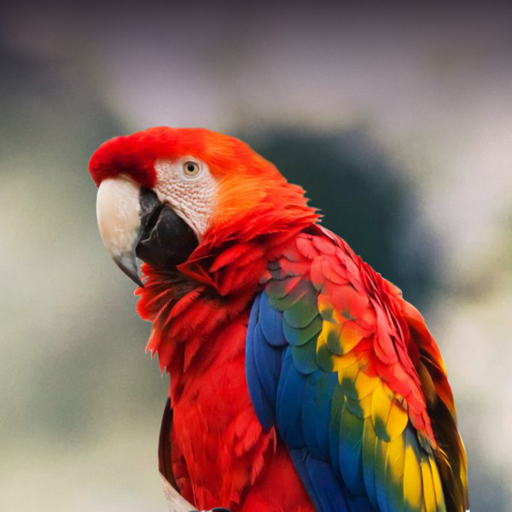

In [8]:
p = FastDownload().download(
    "https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg"
)
img = load_image(p)
# print(f"Dimension of this image: {np.array(img).shape}")
img

In [9]:
latent_img = pil_to_latents(img)
print(f"Dimension of this latent representation: {latent_img.shape}")

Dimension of this latent representation: torch.Size([1, 4, 64, 64])


In [16]:
from diffusers import UNet2DConditionModel, LMSDiscreteScheduler

# Initializing a scheduler
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
# Setting number of sampling steps
scheduler.set_timesteps(51)

# Initializing the model
model = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

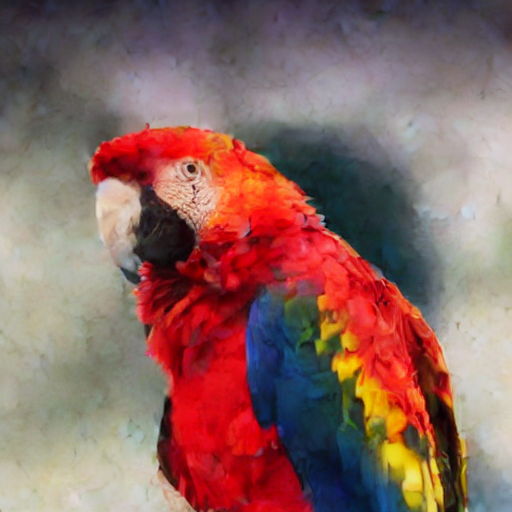

In [17]:
noise = torch.randn_like(latent_img)  # Random noise

encoded_and_noised = scheduler.add_noise(
    latent_img, noise, timesteps=torch.tensor([scheduler.timesteps[40]]))

latents_to_pil(encoded_and_noised)[0]
# Unconditional textual prompt
prompt = ["wearing a sombrero"]

# Using clip model to get embeddings
text_input = tokenizer(prompt, padding="max_length",
                       max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]
    # slot_embeddings

# Using U-Net to predict noise
latent_model_input = torch.cat([encoded_and_noised.to("cuda").float()]).half()
with torch.no_grad():
    noise_pred = model(latent_model_input, 40,
                       encoder_hidden_states=text_embeddings)["sample"]

# Visualize after subtracting noise
latents_to_pil(encoded_and_noised - noise_pred)[0]